#第4章 画像分類
##第4.2節 畳み込みニューラルネットワークによる手法～ResNet18を実装してみよう

###モジュールのインポート

In [ ]:
from collections import deque
import copy
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as T

# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/4_classification/4_2_cnn')

import util
import eval

###各チャネルのデータセット全体の平均と標準偏差を計算する関数

In [ ]:
'''
dataset: 平均と標準偏差を計算する対象のPyTorchのデータセット
'''
def get_dataset_statistics(dataset: Dataset):
    data = []
    for i in range(len(dataset)):
        # [チャネル数, 高さ, 幅]の画像を取得
        img = dataset[i][0]
        data.append(img)
    data = torch.stack(data)

    # 各チャネルの平均と標準偏差を計算
    channel_mean = data.mean(dim=(0, 2, 3))
    channel_std = data.std(dim=(0, 2, 3))

    return channel_mean, channel_std

###ResNet18の基本ブロックの実装

In [ ]:
class BasicBlock(nn.Module):
    ''' 
    ResNet18における残差ブロック
    in_channels : 入力チャネル数
    out_channels: 出力チャネル数
    stride      : 畳み込み層のストライド
    '''
    def __init__(self, in_channels: int, out_channels: int,
                 stride: int=1):
        super().__init__()

        ''''' 残差接続 '''''
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        ''''''''''''''''''''

        # strideが1より大きいときにスキップ接続と残差接続の高さと幅を
        # 合わせるため、別途畳み込み演算を用意
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    '''
    順伝播関数
    x: 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        ''''' 残差接続 '''''
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        ''''''''''''''''''''

        if self.downsample is not None:
            x = self.downsample(x)

        # 残差写像と恒等写像の要素毎の和を計算
        out += x

        out = self.relu(out)

        return out


###ResNet18の実装

In [ ]:
class ResNet18(nn.Module):
    '''
    ResNet18モデル
    num_classes: 分類対象の物体クラス数
    '''
    def __init__(self, num_classes: int):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=3,
                                     stride=2, padding=1)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512),
        )

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.linear = nn.Linear(512, num_classes)

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, x: torch.Tensor, return_embed: bool=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.flatten(1)

        if return_embed:
            return x

        x = self.linear(x)

        return x

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

###学習・評価におけるハイパーパラメータやオプションの設定

In [ ]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.2
        # 学習エポック数
        self.num_epochs = 30
        # 検証する学習率
        self.lr = 1e-2
        # 移動平均で計算する損失と正確度の値の数
        self.moving_avg = 20
        # バッチサイズ
        self.batch_size = 32
        # データローダーに使うCPUプロセスの数
        self.num_workers = 2
        # 学習に使うデバイス
        self.device = 'cuda'
        # t-SNEでプロットするサンプル数
        self.num_samples = 200

###学習・評価を行う関数

In [ ]:
def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各チャネルの平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=T.ToTensor())
    channel_mean, channel_std = get_dataset_statistics(dataset)

    # 画像の整形を行うクラスのインスタンスを用意
    transforms = T.Compose((
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=transforms)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=transforms)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)
    
    # 目的関数の生成
    loss_func = F.cross_entropy

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    
    # ResNet18モデルの生成
    model = ResNet18(len(train_dataset.classes))

    # モデルを指定デバイスに転送(デフォルトはGPU)
    model.to(config.device)

    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()
            
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())
                    
                # パラメータの勾配をリセット
                optimizer.zero_grad()

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == \
                            y).float().mean()

                # 誤差逆伝播
                loss.backward()

                # パラメータの更新
                optimizer.step()

                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()})

        # 検証セットを使って精度評価
        val_loss, val_accuracy = eval.evaluate(
            val_loader, model, loss_func)
        print(f'検証　: loss = {val_loss:.3f}, '
                f'accuracy = {val_accuracy:.3f}')

        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()

    # テスト
    test_loss, test_accuracy = eval.evaluate(
        test_loader, model_best, loss_func)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')
    
    # t-SNEを使って特徴量の分布をプロット
    util.plot_t_sne(test_loader, model_best, config.num_samples)

###学習・評価の実行

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


[エポック 1]: 100%|██████████| 1250/1250 [00:35<00:00, 34.94it/s, loss=1.24, accuracy=0.536]


検証　: loss = 1.144, accuracy = 0.595


[エポック 2]: 100%|██████████| 1250/1250 [00:29<00:00, 41.89it/s, loss=1.07, accuracy=0.605]


検証　: loss = 0.980, accuracy = 0.655


[エポック 3]: 100%|██████████| 1250/1250 [00:29<00:00, 42.07it/s, loss=0.904, accuracy=0.667]


検証　: loss = 0.895, accuracy = 0.690


[エポック 4]: 100%|██████████| 1250/1250 [00:29<00:00, 42.17it/s, loss=0.699, accuracy=0.756]


検証　: loss = 0.851, accuracy = 0.711


[エポック 5]: 100%|██████████| 1250/1250 [00:29<00:00, 42.02it/s, loss=0.623, accuracy=0.772]


検証　: loss = 0.840, accuracy = 0.717


[エポック 6]: 100%|██████████| 1250/1250 [00:32<00:00, 38.38it/s, loss=0.52, accuracy=0.827]


検証　: loss = 0.871, accuracy = 0.717


[エポック 7]: 100%|██████████| 1250/1250 [00:29<00:00, 42.57it/s, loss=0.417, accuracy=0.859]


検証　: loss = 0.867, accuracy = 0.727


[エポック 8]: 100%|██████████| 1250/1250 [00:29<00:00, 41.72it/s, loss=0.419, accuracy=0.845]


検証　: loss = 0.925, accuracy = 0.714


[エポック 9]: 100%|██████████| 1250/1250 [00:30<00:00, 41.47it/s, loss=0.275, accuracy=0.908]


検証　: loss = 0.891, accuracy = 0.739


[エポック 10]: 100%|██████████| 1250/1250 [00:29<00:00, 41.95it/s, loss=0.24, accuracy=0.919]


検証　: loss = 1.011, accuracy = 0.725


[エポック 11]: 100%|██████████| 1250/1250 [00:29<00:00, 42.24it/s, loss=0.265, accuracy=0.914]


検証　: loss = 1.107, accuracy = 0.718


[エポック 12]: 100%|██████████| 1250/1250 [00:29<00:00, 41.84it/s, loss=0.208, accuracy=0.927]


検証　: loss = 1.050, accuracy = 0.732


[エポック 13]: 100%|██████████| 1250/1250 [00:30<00:00, 41.43it/s, loss=0.167, accuracy=0.939]


検証　: loss = 1.096, accuracy = 0.729


[エポック 14]: 100%|██████████| 1250/1250 [00:29<00:00, 41.70it/s, loss=0.123, accuracy=0.953]


検証　: loss = 1.114, accuracy = 0.735


[エポック 15]: 100%|██████████| 1250/1250 [00:31<00:00, 39.17it/s, loss=0.109, accuracy=0.966]


検証　: loss = 1.139, accuracy = 0.738


[エポック 16]: 100%|██████████| 1250/1250 [00:29<00:00, 42.10it/s, loss=0.0978, accuracy=0.958]


検証　: loss = 1.278, accuracy = 0.729


[エポック 17]: 100%|██████████| 1250/1250 [00:30<00:00, 41.64it/s, loss=0.0488, accuracy=0.984]


検証　: loss = 1.204, accuracy = 0.745


[エポック 18]: 100%|██████████| 1250/1250 [00:30<00:00, 41.64it/s, loss=0.136, accuracy=0.945]


検証　: loss = 1.297, accuracy = 0.736


[エポック 19]: 100%|██████████| 1250/1250 [00:29<00:00, 42.06it/s, loss=0.109, accuracy=0.958]


検証　: loss = 1.287, accuracy = 0.736


[エポック 20]: 100%|██████████| 1250/1250 [00:30<00:00, 41.47it/s, loss=0.0628, accuracy=0.981]


検証　: loss = 1.279, accuracy = 0.743


[エポック 21]: 100%|██████████| 1250/1250 [00:32<00:00, 39.03it/s, loss=0.0882, accuracy=0.978]


検証　: loss = 1.372, accuracy = 0.736


[エポック 22]: 100%|██████████| 1250/1250 [00:29<00:00, 41.93it/s, loss=0.0774, accuracy=0.977]


検証　: loss = 1.303, accuracy = 0.743


[エポック 23]: 100%|██████████| 1250/1250 [00:32<00:00, 38.85it/s, loss=0.0302, accuracy=0.995]


検証　: loss = 1.339, accuracy = 0.742


[エポック 24]: 100%|██████████| 1250/1250 [00:29<00:00, 42.00it/s, loss=0.0454, accuracy=0.984]


検証　: loss = 1.378, accuracy = 0.748


[エポック 25]: 100%|██████████| 1250/1250 [00:29<00:00, 41.90it/s, loss=0.0288, accuracy=0.991]


検証　: loss = 1.333, accuracy = 0.747


[エポック 26]: 100%|██████████| 1250/1250 [00:30<00:00, 41.64it/s, loss=0.0424, accuracy=0.983]


検証　: loss = 1.379, accuracy = 0.748


[エポック 27]: 100%|██████████| 1250/1250 [00:30<00:00, 41.24it/s, loss=0.0202, accuracy=0.994]


検証　: loss = 1.395, accuracy = 0.745


[エポック 28]: 100%|██████████| 1250/1250 [00:30<00:00, 41.52it/s, loss=0.0233, accuracy=0.995]


検証　: loss = 1.413, accuracy = 0.744


[エポック 29]: 100%|██████████| 1250/1250 [00:30<00:00, 41.24it/s, loss=0.0598, accuracy=0.984]


検証　: loss = 1.483, accuracy = 0.736


[エポック 30]: 100%|██████████| 1250/1250 [00:30<00:00, 41.15it/s, loss=0.0251, accuracy=0.991]


検証　: loss = 1.499, accuracy = 0.743
テスト: loss = 0.855, accuracy = 0.710


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


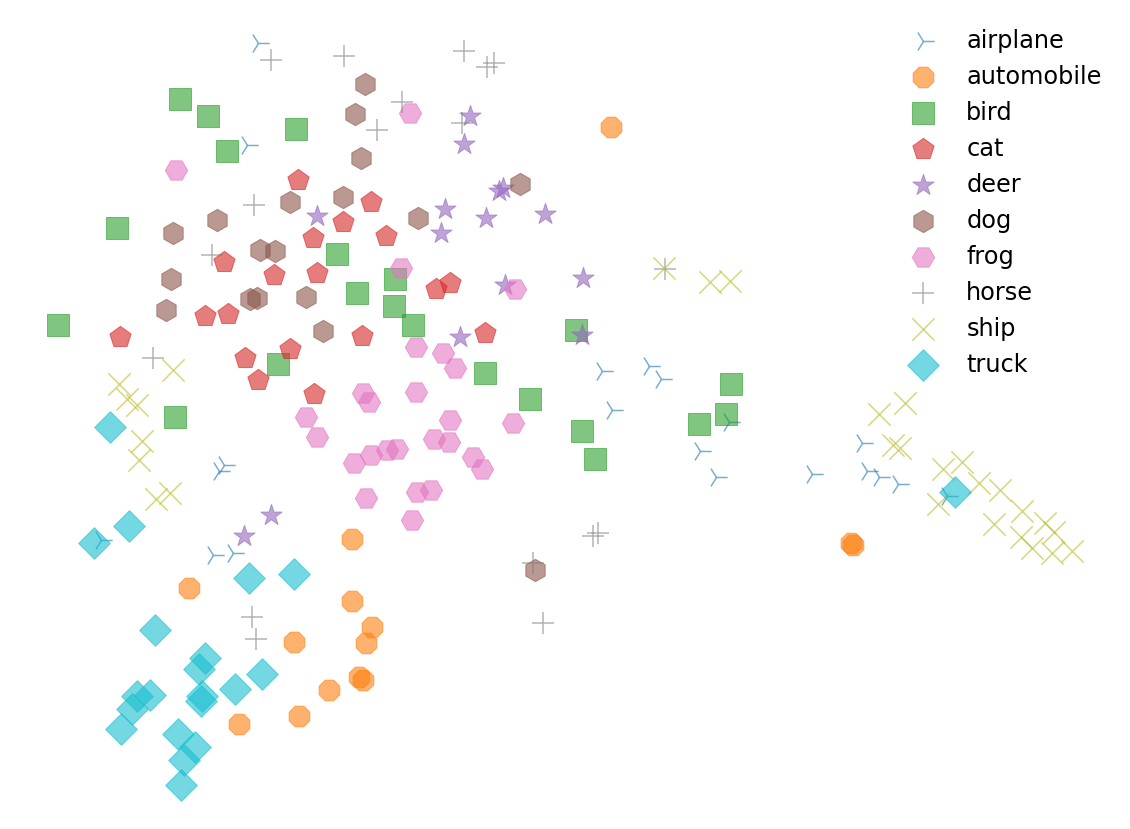

In [ ]:
train_eval()